In [2]:
import keras
keras.__version__

'2.1.3'

### 뉴스기사 분류
- 다중 분류 문제
- 로이터 뉴스를 46개의 주제로 나누는 문제
- 출력은 하나만 선택해야 하므로 single label 다중분류 문제라고 한다

- 로이터 데이터셋 (1986년 생성)으로 Keras에서 제공한다

In [3]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 4s 2us/step

- 자주 발생하는 10000단어로 제한했다
- 데이의 크기를 보겠다.

In [4]:
len(train_data)

8982

In [5]:
len(test_data)

2246

- 각 뉴스의 단어는 이미 숫자로 표현되어 있다.

In [7]:
train_data[0]

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

- 원래의 단어로 복원해서 보는 방법

In [8]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 2s 3us/step


In [43]:
# 첫번째 기사보기
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

- 이 문서에 해당하는 토픽 번호를 확인한다

In [11]:
train_labels[0]

3

### 데이터 준비
- 벡터로 표현하겠다. 10000차원의 one-hot 코딩

In [13]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

In [45]:
x_train.shape

(8982, 10000)

In [14]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

In [47]:
one_hot_train_labels.shape

(8982, 46)

- 이를 처리하는 내장함수가 있다

In [15]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

### 신경망 구성
- 출력이 46개의 주제이다.
- 따라서 신경망 유닛의 수를 16보다 크게 잡을 필요가 있다. 64를 사용하겠다.

In [20]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

- 출력단의 크기를 46으로 했다. softmax를 사용하여 분류의 확률을 계산한다. 확률의 총 합은 1이 된다.
- 성능 척도는 categorical_crossentropy를 사용한다.

In [21]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 검증 데이터

검증용 데이터로 1000개를 사용한다.

20 이포크를 실행한다.

In [22]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [23]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 73us/step - loss: 2.4997 - acc: 0.4899 - val_loss: 1.6813 - val_acc: 0.6480
Epoch 2/20
7982/7982 [==============================] - 1s 63us/step - loss: 1.3915 - acc: 0.7038 - val_loss: 1.2790 - val_acc: 0.7190

손실과 정확도를 출력해보겠다.

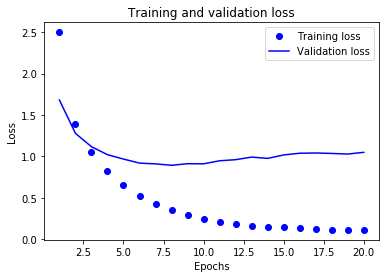

In [24]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

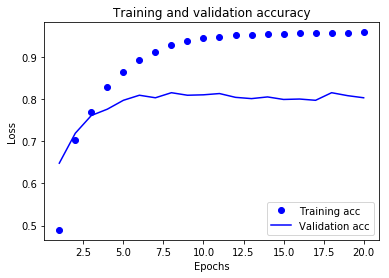

In [25]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

8 이포크 이후 과적합되는 것을 볼 수 있다.

In [26]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 69us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/8
7982/7982 [==============================] - 0s 62us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210

In [27]:
results

[0.9847470450804686, 0.7845057880676759]

### 정확도 78.4%이다.
- 랜덤하게 예측하면, 아래에 보인바와 같이 평균 18%로 맞추었다.

In [30]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19011576135351738

테스트 데이터에 대해서 모델을 적용하겠다.

In [31]:
predictions = model.predict(x_test)

예측한 결과는 46크기의 벡터이다. 테스트 데이터 샘플 수는 2246개이다

Each entry in `predictions` is a vector of length 46:

In [34]:
predictions.shape

(2246, 46)

벡터의 합은 1이 되도록 정의되었다.

In [35]:
np.sum(predictions[0])

0.99999994

확률이 가장 높에 예측되는 위치가 다중 클래스 분류 예측값이다.

In [38]:
np.argmax(predictions[0])

3

In [39]:
np.argmax(predictions[1])

10

### 레이블을 다르게 표현하기
- 레이블을 카테고리가 아니라 정수로 구성된 텐서로 설정할 수도 있다.

In [40]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

- 출력의 타입이 달라졌으므로 손실함수를 다르게 정의해야 한다. 정수형 레이블을 사용하면 sparse_categorical_crossentropy를 사용해야 한다.

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

- 이 손실함수도 내부적으로는 categorical_crossentropy를 사용할 때와 동일하게 계산된다. 단지 출력 변수 타입이 달라졌을 뿐이다.

### 중간 계층을 많이 사용하는 경우
- 중간 계층의 유닛수를 매우 적게 만들면 어떤 현상이 발생하는지 살펴보자
- 유닛수를 4로 설정했다.

In [42]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 113us/step - loss: 3.4942 - acc: 0.0613 - val_loss: 3.0991 - val_acc: 0.2320

- 정확도의 최고치가 70%정도로 낮아졌다.그 이유는 중간 계층의 유닛수를 크게 줄였기 때문이다.

- 추가 실험으로 유닛수를 32, 128 등으로 바꾸어 본다
- 계층의 수를 1, 3 등으로 바꾸어 본다

### 정리
- N 개의 클래스를 분류하려면 출력단은 N 개의 출력을 갖는 Dense 계층을 사용한다
- 단일 레이블 분류 문제라면 softmax 활성화 함수를 사용한다. (각 N으로 분류될 확률을 구한다)
- 분류 작업에서는 Categorical crossentropy 를 손실함수로 주로 사용한다
- 레이블을 코딩하는 방법은 크게 두가지가 있다.
    - 레이블을 카테고리로 코딩한다 (one-hot 코딩)
    - 정수 벡터로 코딩한다 (sparse_categorical_crossentropy 손실함수를 사용)
- 다중 분류를 하는경우 중간 계층의 유닛수를 너무 작게 하면 안된다.